# Audit Data EDA & Chunking Analysis

이 노트북은 `data_v10.json` 데이터의 분포를 분석하고, RAG를 위한 청킹(Chunking) 전략이 적절한지 시각적으로 확인하기 위해 작성되었습니다.

**주요 분석 내용**:
1. **데이터 길이 분포**: `contents`, `problem`, 그리고 병합된 텍스트의 길이 분석
2. **청킹 시뮬레이션**: 설정된 Chunk Size(800)로 잘랐을 때 실제 데이터가 어떻게 나뉘는지 확인

In [1]:
# 필요한 라이브러리 설치 (없을 경우)
# %pip install pandas matplotlib seaborn

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys

# 한글 폰트 설정 (Mac OS 기준)
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# Config 불러오기
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from config import Config

# 데이터 로드
DATA_PATH = "../data_v10.json"
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"Total Documents: {len(data)}")

Total Documents: 4961


## 1. 텍스트 길이 분석 (Length Distribution)

RAG 성능에 가장 중요한 것은 **청킹(Chunking)**입니다. 청킹 전략을 세우기 위해 원본 데이터의 길이를 분석합니다.

- **Contents**: 상세 내용
- **Problem**: 지적 사항 (핵심 요약)
- **Merged**: Problem + Contents (실제 임베딩 대상)

In [3]:
# 데이터 프레임 변환 및 길이 계산
# contents_summary에서 title, problem 추출 로직 적용 (ingest.py와 동일)
processed_data = []
for item in data:
    problem = item.get('problem', '')
    title = item.get('title', '')
    contents = item.get('contents', '')
    idx = item.get('idx')

    summary_raw = item.get('contents_summary')
    if isinstance(summary_raw, str):
        try:
            summary_json = json.loads(summary_raw)
            if summary_json.get('problems'):
                problem = summary_json.get('problems')
            if summary_json.get('title'):
                title = summary_json.get('title')
        except:
            pass
    elif isinstance(summary_raw, dict):
        if summary_raw.get('problems'):
            problem = summary_raw.get('problems')
        if summary_raw.get('title'):
            title = summary_raw.get('title')
            
    # Fallback to root 'problem' if not found in summary
    if not problem:
        problem = item.get('problem', '')
            
    processed_data.append({
        'idx': idx,
        'title': title,
        'problem': problem,
        'contents': contents
    })

df = pd.DataFrame(processed_data)

# 길이 계산 (글자 수 기준)
df['len_contents'] = df['contents'].fillna('').apply(len)
df['len_problem'] = df['problem'].fillna('').apply(len)
df['len_merged'] = df['len_problem'] + df['len_contents'] + 10 # +10 for formatting chars

df[['len_contents', 'len_problem', 'len_merged']].describe()

,len_contents,len_problem,len_merged
count,4961.000000,4961.000000,4961.000000
mean,1413.240274,152.858496,1576.098770
std,1551.918587,94.933502,1601.338486
min,7.000000,4.000000,24.000000
25%,511.000000,85.000000,598.000000
50%,884.000000,136.000000,1043.000000
75%,1740.000000,201.000000,1946.000000
max,12653.000000,975.000000,12821.000000


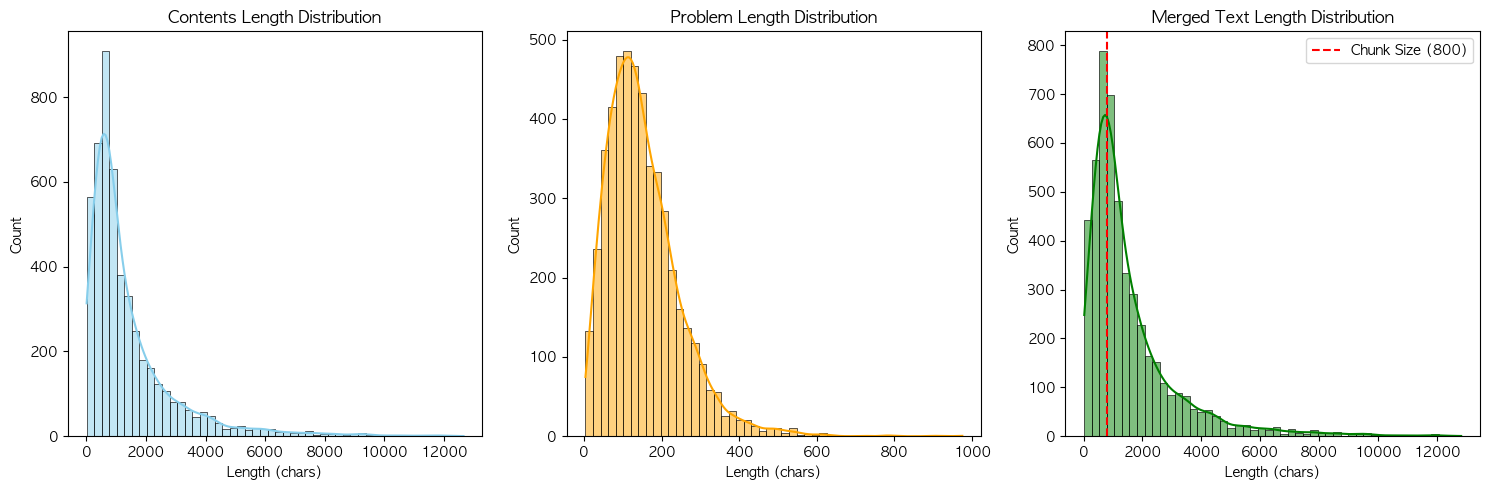

In [4]:
# 히스토그램 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['len_contents'], bins=50, kde=True, color='skyblue')
plt.title('Contents Length Distribution')
plt.xlabel('Length (chars)')

plt.subplot(1, 3, 2)
sns.histplot(df['len_problem'], bins=50, kde=True, color='orange')
plt.title('Problem Length Distribution')
plt.xlabel('Length (chars)')

plt.subplot(1, 3, 3)
sns.histplot(df['len_merged'], bins=50, kde=True, color='green')
plt.axvline(x=800, color='r', linestyle='--', label='Chunk Size (800)')
plt.title('Merged Text Length Distribution')
plt.xlabel('Length (chars)')
plt.legend()

plt.tight_layout()
plt.show()

### 분석 포인트
- **Merged Text**의 분포를 보세요. 
- 빨간 점선(800자)보다 왼쪽에 있는 데이터는 **한 번에(1 Chunk)** 들어가는 데이터입니다.
- 오른쪽에 있는 데이터는 **여러 개로 쪼개지는(Multi-Chunk)** 데이터입니다.
- 대부분의 데이터가 800자 이내라면, 문맥 손실 없이 온전한 정보를 검색할 수 있어 유리합니다.

## 2. 청킹 시뮬레이션 (Chunking Visualization)

실제 `RecursiveCharacterTextSplitter`를 사용하여 긴 문서가 어떻게 잘리는지 눈으로 확인합니다.

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Config 설정 가져오기
CHUNK_SIZE = Config.CHUNK_SIZE
CHUNK_OVERLAP = Config.CHUNK_OVERLAP

print(f"Current Strategy: Chunk Size = {CHUNK_SIZE}, Overlap = {CHUNK_OVERLAP}")

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    separators=["\n\n", "\n", " ", ""]
)

Current Strategy: Chunk Size = 1000, Overlap = 200


In [6]:
from IPython.display import display, HTML

def visualize_chunk_overlaps(chunks):
    html = ""
    html += "<div style='margin-bottom: 20px;'>"
    html += "<b>Legend:</b> "
    html += "<span style='background-color: #e6f3ff; color: blue; padding: 2px 5px; margin-right: 10px;'>Overlap with Previous</span>"
    html += "<span style='background-color: #ffe6e6; color: red; padding: 2px 5px;'>Overlap with Next</span>"
    html += "</div>"

    for i, chunk in enumerate(chunks):
        text = chunk.page_content
        
        # Calculate overlaps
        prev_overlap_len = 0
        if i > 0:
            prev_text = chunks[i-1].page_content
            # Check suffixes of prev_text against prefixes of text
            search_len = min(len(text), len(prev_text), Config.CHUNK_OVERLAP + 50) 
            for l in range(search_len, 0, -1):
                if prev_text.endswith(text[:l]):
                    prev_overlap_len = l
                    break
        
        next_overlap_len = 0
        if i < len(chunks) - 1:
            next_text = chunks[i+1].page_content
            search_len = min(len(text), len(next_text), Config.CHUNK_OVERLAP + 50)
            for l in range(search_len, 0, -1):
                if text.endswith(next_text[:l]):
                    next_overlap_len = l
                    break
        
        # Construct HTML for this chunk
        chunk_html = f"<div style='border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; border-radius: 5px;'>"
        chunk_html += f"<div style='font-weight: bold; margin-bottom: 5px;'>Chunk {i+1} (Length: {len(text)})</div>"
        chunk_html += "<div style='white-space: pre-wrap; font-family: monospace; font-size: 0.9em;'>"
        
        p1 = prev_overlap_len
        p2 = len(text) - next_overlap_len
        
        if p1 > p2: # Overlap intersection
             chunk_html += f"<span style='background-color: #e6f3ff; color: blue;'>{text[:p2]}</span>"
             chunk_html += f"<span style='background-color: #e0e0e0;'>{text[p2:p1]}</span>"
             chunk_html += f"<span style='background-color: #ffe6e6; color: red;'>{text[p1:]}</span>"
        else:
            chunk_html += f"<span style='background-color: #e6f3ff; color: blue;'>{text[:p1]}</span>"
            chunk_html += f"<span>{text[p1:p2]}</span>"
            chunk_html += f"<span style='background-color: #ffe6e6; color: red;'>{text[p2:]}</span>"
            
        chunk_html += "</div></div>"
        html += chunk_html
        
    display(HTML(html))

# 긴 문서 샘플 추출 (상위 1% 길이)
long_docs = df[df['len_merged'] > df['len_merged'].quantile(0.99)].sample(1)
sample_idx = long_docs.index[0]
sample_item = data[sample_idx]

problem = sample_item.get('problem', '')
contents = sample_item.get('contents', '')
merged_text = f"Problem: {problem}\n\nContents: {contents}"

print(f"[Original Document ID: {sample_item.get('idx')}]")
print(f"Total Length: {len(merged_text)} chars")
print("="*50)

# 청킹 수행
chunks = text_splitter.create_documents([merged_text])

print(f"Result: Split into {len(chunks)} chunks\n")
visualize_chunk_overlaps(chunks)

[Original Document ID: 422]
Total Length: 15985 chars
Result: Split into 21 chunks



### 확인 포인트
- **Overlap**: Chunk 간에 중복되는 문장이 있는지 확인하세요. 문맥이 끊기지 않도록 연결해주는 역할을 합니다.
- **가독성**: 잘린 위치가 문장 중간이라도 의미 파악이 가능한지 보세요.